# Straight Road With Obstacle Autonomous Driving Scenario
This notebook demonstrates a 2-player autonomous driving scenario. Two players are coordinating to avoid an obstacle on the side of the road. 

In [2]:
using ALGAMES
using BenchmarkTools
using LinearAlgebra
using StaticArrays
using TrajectoryOptimization
const TO = TrajectoryOptimization;

### Define the dynamics model of the game.

In [3]:
struct InertialUnicycleGame{T} <: AbstractGameModel
    n::Int  # Number of states
    m::Int  # Number of controls
    mp::T
    pu::Vector{Vector{Int}} # Indices of the each player's controls
    px::Vector{Vector{Int}} # Indices of the each player's x and y positions
    p::Int  # Number of players
end
InertialUnicycleGame() = InertialUnicycleGame(
    8,
    4,
    1.0,
    [[1,2],[3,4]],
    [[1,2],[5,6]],
    2)
Base.size(::InertialUnicycleGame) = 8,4,[[1,2],[3,4]],2; # n,m,pu,p

### Instantiate dynamics model

In [4]:
model = InertialUnicycleGame()
n,m,pu,p = size(model)
T = Float64
px = model.px


# We use the unicycle dynamics for each player. 
# State   x = [px1, py1, θ1, v1, px2, py2, θ2, v2] 
# Control u = [θ1, v1, θ2, v2]
# px1 = x position of player 1 
# py1 = y position of player 1 
# θ1 = orientation of player 1 
# v1 = x velocity of player 1 

function TO.dynamics(model::InertialUnicycleGame, x, u) # Non memory allocating dynamics
    qd1 = @SVector [cos(x[3]), sin(x[3])]
    qd1 *= x[4]
    qd2 = @SVector [cos(x[7]), sin(x[7])]
    qd2 *= x[8]
    qdd1 = u[ @SVector [1,2] ]
    qdd2 = u[ @SVector [3,4] ]
    return [qd1; qdd1; qd2; qdd2]
end;

### Discretization of the trajectories

In [5]:
tf = 3.0  # final time
N = 41    # number of knot points
dt = tf / (N-1); # time step duration

### Initial and final state definition

In [6]:
# Define initial and final states (be sure to use Static Vectors!)
x0 = @SVector  [
               -1.00,  0.10, 0.00,  0.60, #player 1 x,y,θ,v
               -1.00, -0.10, 0.00,  0.60, #player 2 x,y,θ,v
                ]
xf = @SVector [
                1.00,  0.10, 0.00, 0.60, #player 1 x,y,θ,v
                1.00, -0.05, 0.00, 0.80, #player 2 x,y,θ,v
               ];

### Define players objective functions

In [7]:
# Define quadratic costs
diag_Q1 = @SVector [ # Player 1 state cost
    0., 10., 1., 1.,
    0., 0., 0., 0.]
diag_Q2 = @SVector [ # Player 2 state cost
    0., 0., 0., 0.,
    0., 10., 1., 1.]

# Players stage state costs
Q = [0.1*Diagonal(diag_Q1), 
     0.1*Diagonal(diag_Q2)]

# Players final state costs
Qf = [1.0*Diagonal(diag_Q1),
      1.0*Diagonal(diag_Q2)]

# Players controls costs
R = [0.1*Diagonal(@SVector ones(length(pu[1]))),
     0.1*Diagonal(@SVector ones(length(pu[2]))),
    ]

# Players objectives
obj = [LQRObjective(Q[i],R[i],Qf[i],xf,N) for i=1:p];

### Define the initial trajectory

In [8]:
xs = SVector{n}(zeros(n))
us = SVector{m}(zeros(m))
Z = [KnotPoint(xs,us,dt) for k = 1:N]
Z[end] = KnotPoint(xs,m);

### Build the straight road with obstacle scenario

In [9]:
# Actors 
actor_radius = 0.08
actors_radii = [actor_radius for i=1:p]
actors_types = [:car, :car]

#Scene
road_length = 3.0   # length of the roadway
road_width = 0.37   # width of the roadway
obs_radius = 0.06   # radius of the obstacle 
obs = [0.50, -0.17] # position of the obstacle

# Build scenario
scenario = StraightScenario(road_length, road_width,
    actors_radii, actors_types, obs_radius, obs);

### Define constraints of the problem

In [10]:
# Create constraint sets
conSet = ConstraintSet(n,m,N)
con_inds = 2:N # Indices where the constraints will be applied

# Add collision avoidance constraints
add_collision_avoidance(conSet, actors_radii, px, p, con_inds)

# Add scenario specific constraints (road boundaries)
add_scenario_constraints(conSet, scenario, px, con_inds; constraint_type=:constraint);

### Define the problem we will be solving

In [11]:
prob = GameProblem(model, obj, conSet, x0, xf, Z, N, tf);

### Build the ALGAMES solver 

In [14]:
opts = DirectGamesSolverOptions{T}(
    iterations=10,
    inner_iterations=20,
    iterations_linesearch=10)
solver = DirectGamesSolver(prob, opts);

### Solve the problem

In [15]:
@time solve!(solver);

  0.049904 seconds (86.10 k allocations: 13.192 MiB, 36.36% gc time)


┌ Info: ("Solver iteration = ", 1)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/direct/direct_methods.jl:39
┌ Info: ("Solver iteration = ", 2)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/direct/direct_methods.jl:39
┌ Info: ("Solver iteration = ", 3)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/direct/direct_methods.jl:39
┌ Info: ("Solver iteration = ", 4)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/direct/direct_methods.jl:39
┌ Info: ("Solver iteration = ", 5)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/direct/direct_methods.jl:39
┌ Info: Outer loop converged: cost_tolerance & constraint_tolerance
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/direct/direct_methods.jl:146


### Evaluate the solve time

In [16]:
opts = DirectGamesSolverOptions{T}(
    iterations=10,
    inner_iterations=20,
    iterations_linesearch=10,
    log_level=ALGAMES.Logging.Warn)
solver = DirectGamesSolver(prob, opts)
@btime timing_solve(solver);

  15.800 ms (21464 allocations: 9.47 MiB)


### Visualize state and control trajectories

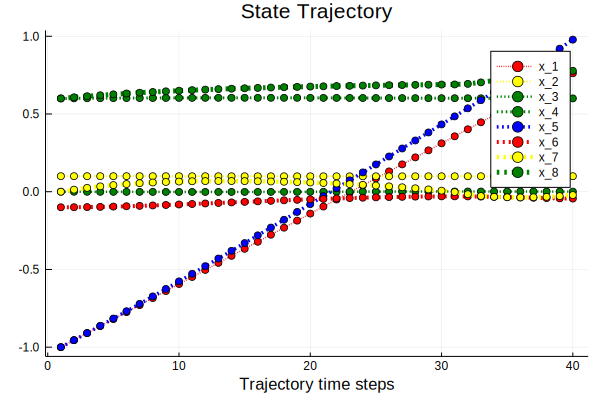

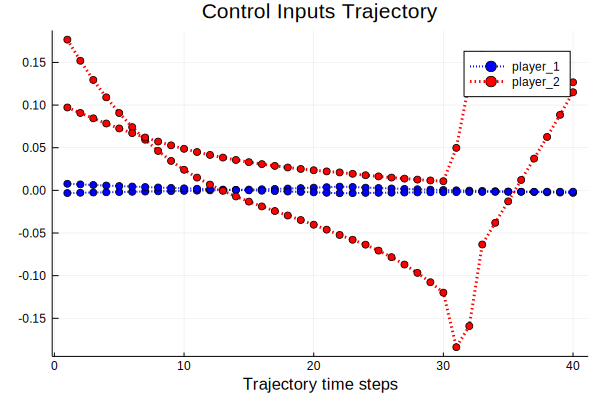

In [17]:
X = TO.states(solver)
U = TO.controls(solver)
visualize_state(X)
visualize_control(U,pu)

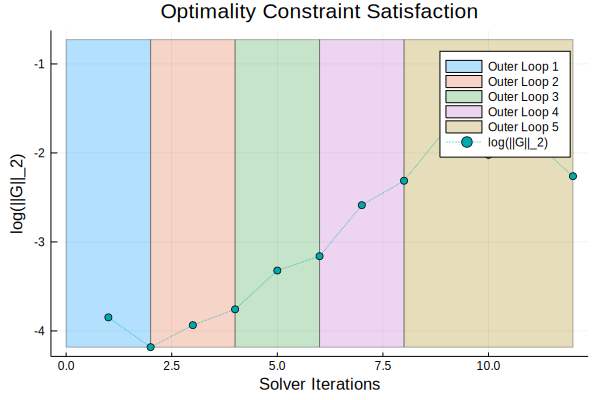

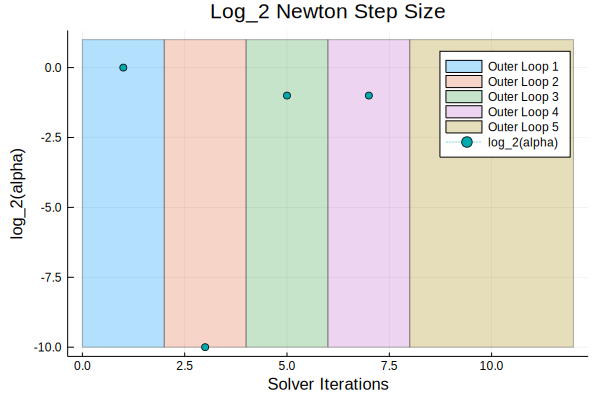

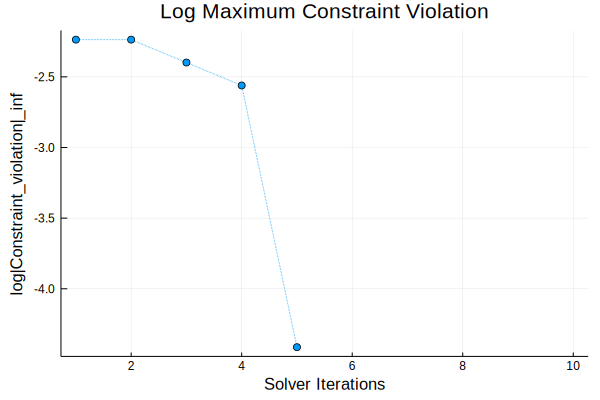

In [18]:
visualize_optimality_merit(solver)
visualize_α(solver)
visualize_cmax(solver)

### Create a 3D visualization in MeshCat

In [20]:
vis=ALGAMES.Visualizer()
anim=ALGAMES.MeshCat.Animation()

MeshCat.Animation(Dict{MeshCat.SceneTrees.Path,MeshCat.AnimationClip}(), 30)

In [21]:
ALGAMES.MeshCat.render(vis) # To open the visualizer in the notebook
# ALGAMES.MeshCat.open(vis) # To open the visualizer in a new tab

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), Dict{String,MeshCat.SceneTrees.SceneNode}()), Set(Any[]), ip"127.0.0.1", 8702))

### Animate the scene

In [24]:
vis, anim = animation(solver, scenario;
    vis=vis, anim=anim,
    open_vis=false);